In [1]:
from pathlib import Path

import anndata as ad
import lightning as L
import matplotlib.pyplot as plt 
import numpy as np
import scanpy as sc
import torch

from chemCPA.data import PerturbationDataModule, load_dataset_splits
from chemCPA.lightning_module import ChemCPA

In [2]:
ckpt = "last.ckpt"
run_id = "lzrig76f"
cp_path = Path("/nfs/homedirs/hetzell/code/chemCPA/project_folder/checkpoints_hydra") / run_id / ckpt

In [3]:
module = ChemCPA.load_from_checkpoint(cp_path)

In [4]:
data_params = module.config["dataset"]

In [5]:
data_params

{'perturbation_key': 'drug', 'pert_category': 'condition', 'dose_key': 'dose', 'covariate_keys': 'cell_type', 'smiles_key': 'smiles', 'use_drugs_idx': True, 'split_key': 'split', 'dataset_path': 'project_folder/datasets/adata_biolord_split_30.h5ad', 'degs_key': 'rank_genes_groups_cov_all'}

In [6]:
datasets, dataset = load_dataset_splits(**data_params, return_dataset=True)

/nfs/staff-hdd/hetzell/miniconda3/envs/chemCPA-test-env-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
dm = PerturbationDataModule(datasplits=datasets, train_bs=module.config["model"]["hparams"]["batch_size"])
dm.setup(stage="fit")  # fit, validate/test, predict

In [26]:
from chemCPA.train import evaluate_r2

module.model.eval()
with torch.no_grad():
    result = evaluate_r2(
        module.model,
        dm.ood_treated_dataset,
        dm.ood_control_dataset.genes,
    )

evaluation_stats = dict(zip(["R2_mean", "R2_mean_de", "R2_var", "R2_var_de"], result))
evaluation_stats

{'R2_mean': 0.8107627920202307,
 'R2_mean_de': 0.6730566234201998,
 'R2_var': 0.7467480156872723,
 'R2_var_de': 0.5775561236046456}

In [9]:
control_genes = {}

# Iterate over the dataset
_genes = dm.ood_control_dataset.genes
_cov_names = dm.ood_control_dataset.covariate_names["cell_type"]

for covariate, gene in zip(_cov_names, _genes):
    if covariate not in control_genes:
        control_genes[covariate] = gene.unsqueeze(0)
        continue
    control_genes[covariate] = torch.concat([control_genes[covariate], gene.unsqueeze(0)], dim=0)

In [10]:
module.model.eval()
module.model.to("cuda")

preds = {}
targs = {}

for pert_cat, item in zip(dm.ood_treated_dataset.pert_categories, dm.ood_treated_dataset):
    if pert_cat not in preds:
        genes = item[0]
        drug_idx = item[1]
        dosages = item[2]
        covariates = item[4:]
        cl = pert_cat.split("_")[0]
        dose = pert_cat.split("_")[-1]
        drug = "_".join(pert_cat.split("_")[1:-1])

        genes = control_genes[cl]
        n_obs = len(control_genes[cl])

        # repeat torch tensor n_obs times
        drugs_idx = drug_idx.repeat(n_obs)
        dosages = dosages.repeat(n_obs)
        covariates = [cov.repeat(n_obs, 1) for cov in covariates]
        gene_reconstructions, cell_drug_embedding, latent_basal = module.model.predict(
            genes=genes,
            drugs=None,
            drugs_idx=drugs_idx,
            dosages=dosages,
            covariates=covariates,
            return_latent_basal=True,
        )

        dim = gene_reconstructions.size(1) // 2
        mean = gene_reconstructions[:, :dim]
        var = gene_reconstructions[:, dim:]

        preds[pert_cat] = mean.detach().cpu().numpy()
        targs[pert_cat] = (
            (dm.ood_treated_dataset.genes[dm.ood_treated_dataset.pert_categories == pert_cat]).clone().numpy()
        )

In [11]:
predictions = []
targets = []
cl_p = []
cl_t = []
drug_p = []
drug_t = []
dose_p = []
dose_t = []
control = {}
control_cl = {}
for key, val in preds.items():
    cl = key.split("_")[0]
    drug = "_".join(key.split("_")[1:-1])
    dose = key.split("_")[-1]

    control[cl] = control_genes[cl].numpy()
    control_cl[cl] = control[cl].shape[0] * [cl]

    predictions.append(val)
    cl_p.extend(val.shape[0] * [cl])
    drug_p.extend(val.shape[0] * [drug])
    dose_p.extend(val.shape[0] * [float(dose)])

    targets.append(targs[key])
    cl_t.extend(targs[key].shape[0] * [cl])
    drug_t.extend(targs[key].shape[0] * [drug])
    dose_t.extend(targs[key].shape[0] * [float(dose)])

adata_c = ad.AnnData(np.concatenate([control[cl] for cl in control], axis=0))
adata_c.obs["cell_line"] = list(np.concatenate([control_cl[cl] for cl in control], axis=0))
adata_c.obs["condition"] = "control"
adata_c.obs["perturbation"] = "Vehicle"
adata_c.obs["dose"] = 1.0

adata_p = ad.AnnData(np.concatenate(predictions, axis=0))
adata_p.obs["condition"] = "prediction"
adata_p.obs["cell_line"] = cl_p
adata_p.obs["perturbation"] = drug_p
adata_p.obs["dose"] = dose_p


adata_t = ad.AnnData(np.concatenate(targets, axis=0))
adata_t.obs["condition"] = "target"
adata_t.obs["cell_line"] = cl_t
adata_t.obs["perturbation"] = drug_t
adata_t.obs["dose"] = dose_t

adata = ad.concat([adata_c, adata_p, adata_t])

/nfs/staff-hdd/hetzell/miniconda3/envs/chemCPA-test-env-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata.obs_names_make_unique()
adata.obs["pert_category"] = None

for key in np.unique(dm.ood_treated_dataset.pert_categories):
    cl = key.split("_")[0]
    drug = "_".join(key.split("_")[1:-1])
    dose = float(key.split("_")[-1])

    cond = adata.obs["cell_line"] == cl
    cond *= adata.obs["perturbation"] == drug
    cond *= adata.obs["dose"] == dose
    adata.obs.loc[cond, "pert_category"] = key

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

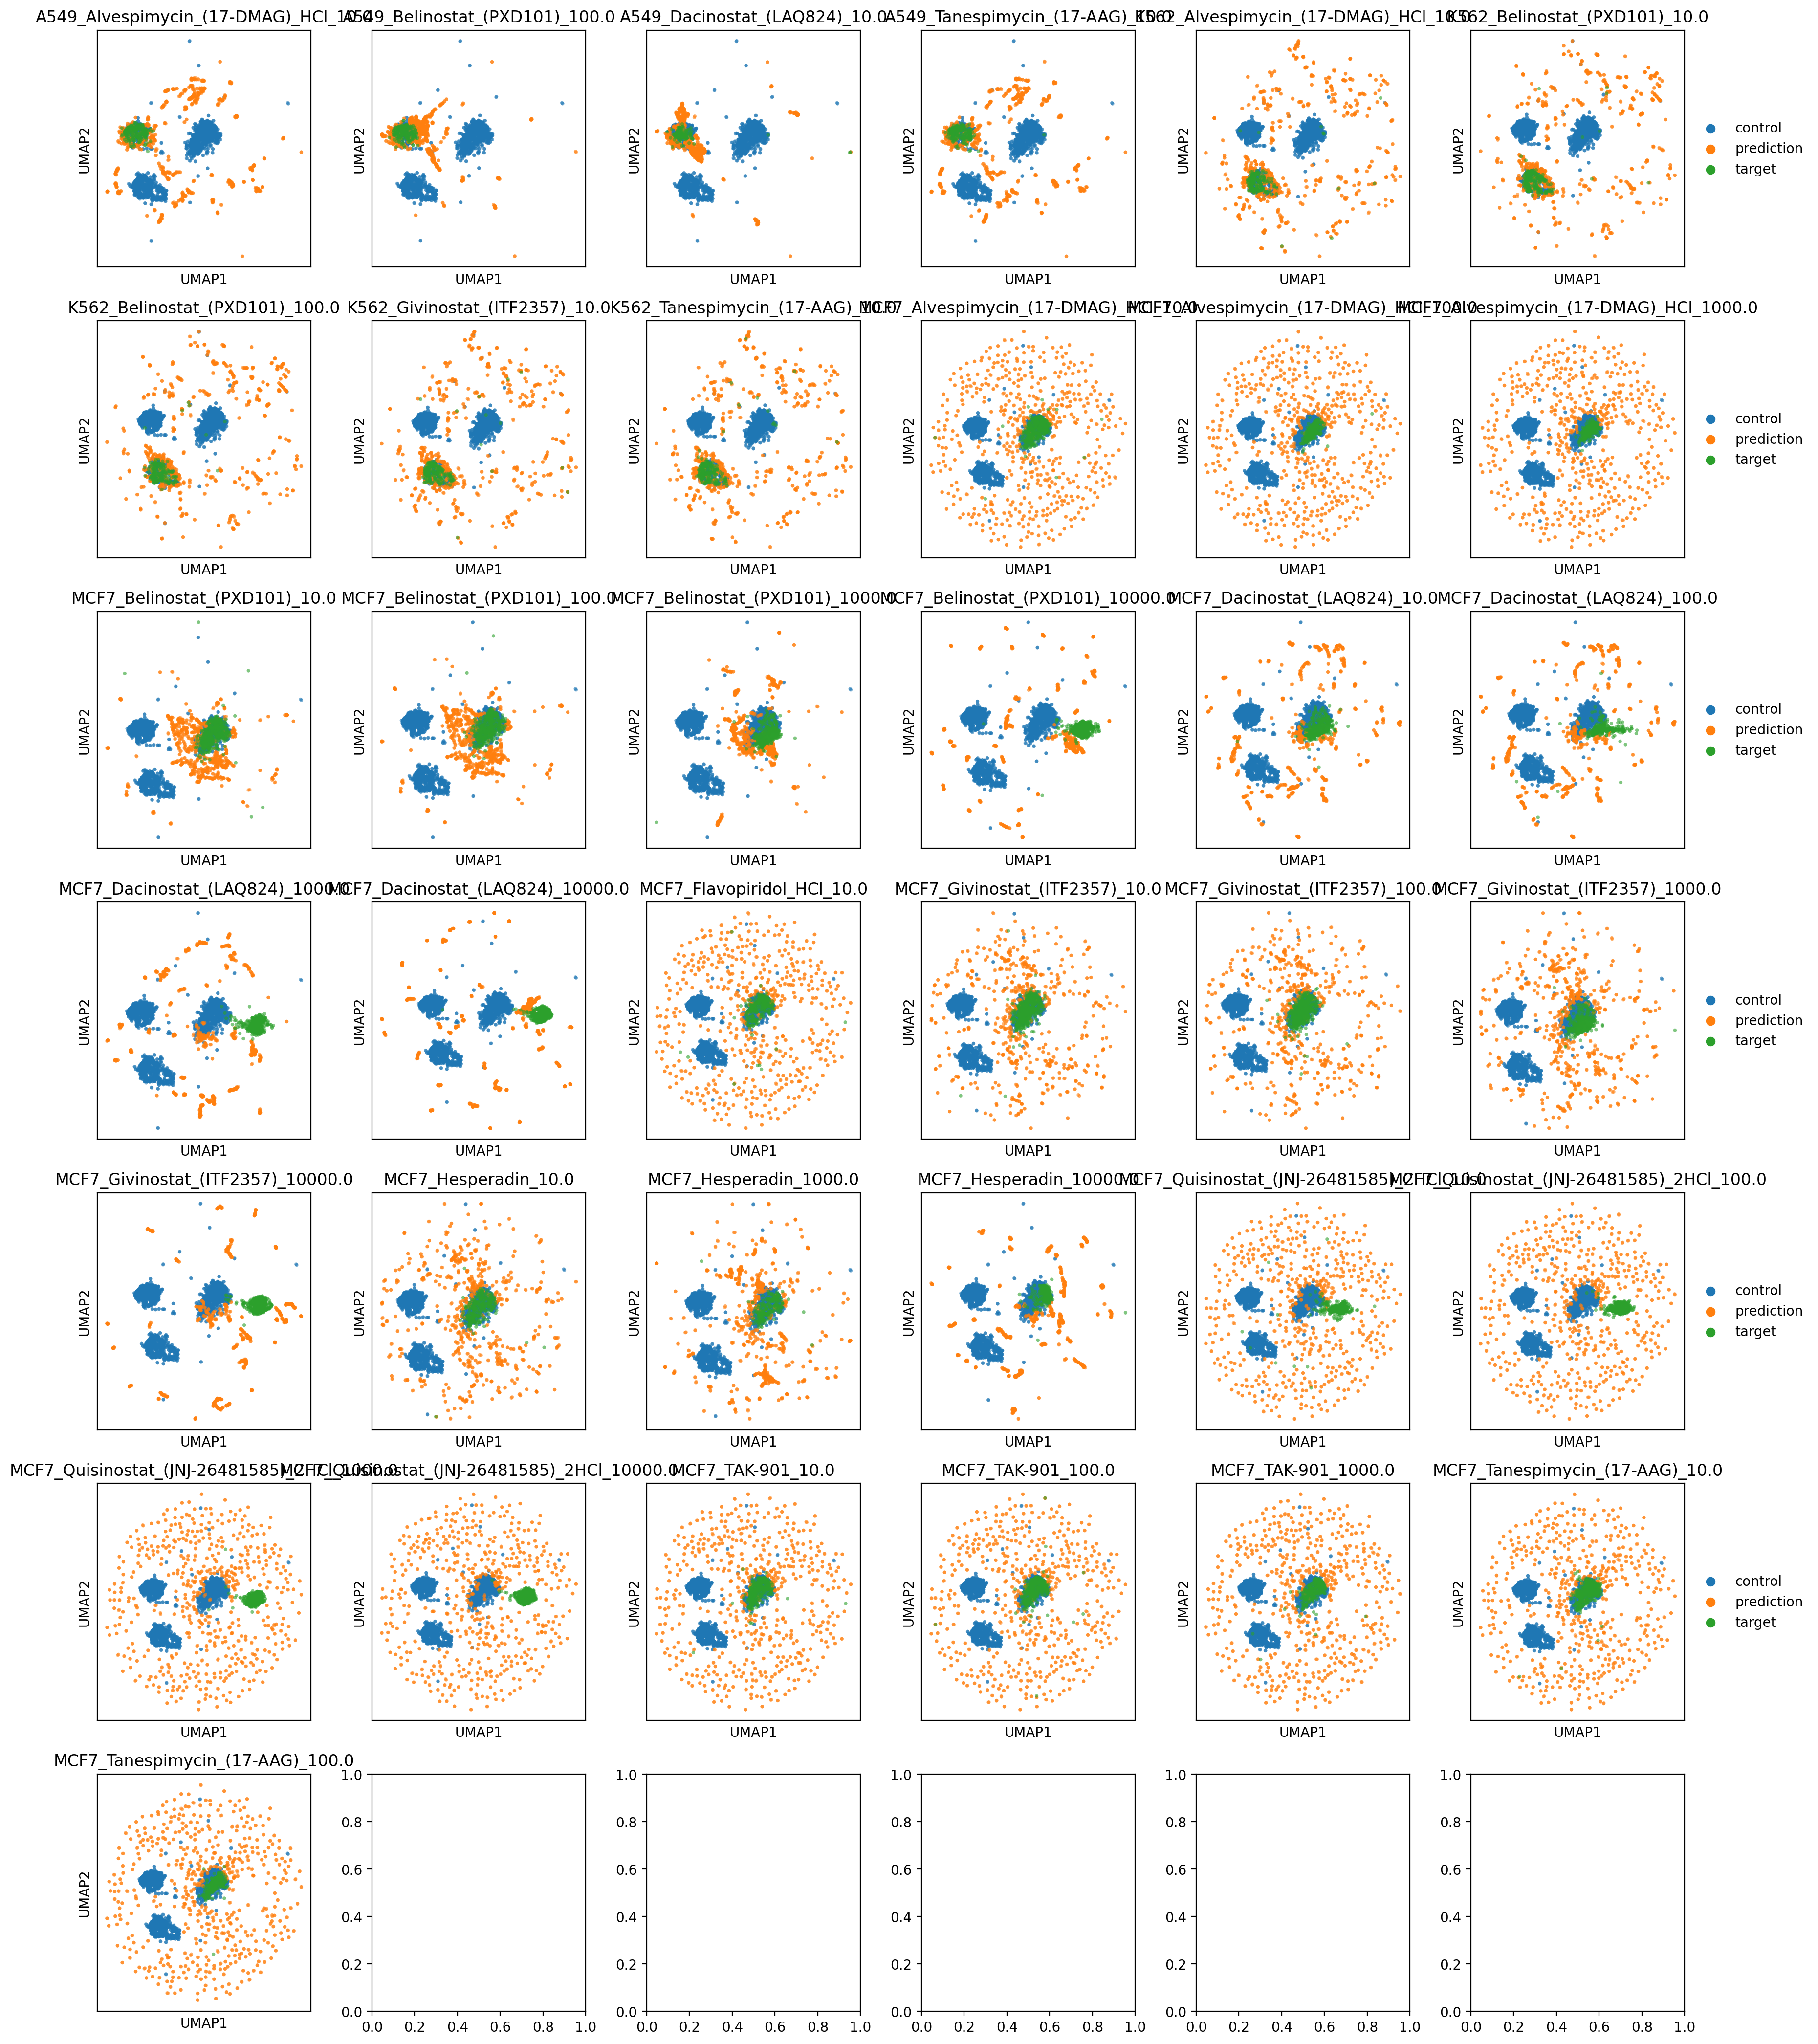

In [37]:
ood_cats = np.unique(dm.ood_treated_dataset.pert_categories)
_adata = adata

cols = 6
rows = len(ood_cats) // cols + 1    

fig, axis = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

for i, key in enumerate(np.unique(dm.ood_treated_dataset.pert_categories)):
    ax = axis[i // cols, i % cols]
    cl = key.split("_")[0]
    drug = "_".join(key.split("_")[1:-1])
    dose = float(key.split("_")[-1])

    cond = _adata.obs["cell_line"] == cl
    cond *= _adata.obs["perturbation"] == drug
    cond *= _adata.obs["dose"] == dose
    cond += _adata.obs["condition"] == "control"
    sc.pl.umap(_adata[cond].copy(), color=["condition"], title=key, show=False, ax=ax, alpha=0.6)
    # remove legend 
    if (i % cols) < (cols -1):
        ax.get_legend().remove()

plt.tight_layout()